In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
!pip install textstat

     |████████████████████████████████| 133kB 7.6MB/s 
     |████████████████████████████████| 102kB 5.8MB/s 
     |████████████████████████████████| 1.9MB 12.9MB/s 


In [3]:
# Required Libraries
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
import textstat
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import bs4
import os
from bs4 import BeautifulSoup as bs
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

## Loading the data

In [4]:
# loading Data
df = pd.read_csv("/content/drive/Shareddrives/Study/SEM 2/IT-550 Information Retrieval/Project/implementation/Dataset and respective papers/[18] hate-speech-and-offensive-language-master/hate-speech-and-offensive-language-master/data/labeled_data.csv")

In [5]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [6]:
df.drop('Unnamed: 0',axis='columns', inplace=True)

In [7]:
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [8]:
#Summary of the Data
df.describe()

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


In [9]:
#Column Names
df.columns

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


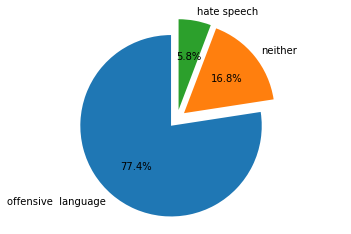

In [10]:
# Distribution of tweet between Hate Speech, Offensive Language and Neither
d = df['class'].value_counts()

import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'offensive  language','neither','hate speech'
sizes = d
explode = ( 0.1, 0.1, 0.1)  )

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
      startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

This piechart shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [11]:
tweets=df.tweet

In [12]:
tweets

0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like I ain...
24781                youu got wild bitches tellin you lies
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

## Feature generation

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
from nltk.tokenize import RegexpTokenizer

In [15]:
stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenizer_(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
     and stems tweets. Returns a list of stemmed tokens."""
    token = RegexpTokenizer(r'\w+')
    t = token.tokenize(tweet)
    t=[word.lower() for word in t if word.isalpha()]
    return t

In [16]:
vectorizer = TfidfVectorizer(
    tokenizer= tokenizer_,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [17]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}

In [18]:
vocab

{'ability': 0,
 'able': 1,
 'abo': 2,
 'abortion': 3,
 'absolute': 4,
 'absolutely': 5,
 'abt': 6,
 'accent': 7,
 'accept': 8,
 'accident': 9,
 'accidentally': 10,
 'according': 11,
 'account': 12,
 'accounts': 13,
 'accurate': 14,
 'across': 15,
 'act': 16,
 'act like': 17,
 'act like bitches': 18,
 'actin': 19,
 'actin like': 20,
 'acting': 21,
 'acting like': 22,
 'acting like bitch': 23,
 'action': 24,
 'actions': 25,
 'active': 26,
 'activities': 27,
 'acts': 28,
 'acts like': 29,
 'actual': 30,
 'actually': 31,
 'ad': 32,
 'adam': 33,
 'add': 34,
 'added': 35,
 'addicted': 36,
 'address': 37,
 'admit': 38,
 'adorable': 39,
 'ads': 40,
 'adult': 41,
 'advice': 42,
 'ae': 43,
 'af': 44,
 'afford': 45,
 'afraid': 46,
 'african': 47,
 'afterwards': 48,
 'age': 49,
 'ago': 50,
 'agree': 51,
 'agreed': 52,
 'ah': 53,
 'ah bitch': 54,
 'aha': 55,
 'ahaha': 56,
 'ahead': 57,
 'ahh': 58,
 'ahhh': 59,
 'aid': 60,
 'aids': 61,
 'aim': 62,
 'ainn': 63,
 'aint': 64,
 'aint bitch': 65,
 'aint 

In [19]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [20]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = tokenizer_(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [21]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [22]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [23]:
pos_vocab

{'CC': 0,
 'CC CC': 1,
 'CC CD': 2,
 'CC CD NN': 3,
 'CC DT': 4,
 'CC DT CC': 5,
 'CC DT IN': 6,
 'CC DT JJ': 7,
 'CC DT NN': 8,
 'CC DT NNS': 9,
 'CC DT PRP': 10,
 'CC DT RB': 11,
 'CC DT VBD': 12,
 'CC DT VBP': 13,
 'CC DT VBZ': 14,
 'CC EX': 15,
 'CC IN': 16,
 'CC IN DT': 17,
 'CC IN JJ': 18,
 'CC IN NN': 19,
 'CC IN NNS': 20,
 'CC IN PRP': 21,
 'CC IN VBP': 22,
 'CC JJ': 23,
 'CC JJ CC': 24,
 'CC JJ DT': 25,
 'CC JJ IN': 26,
 'CC JJ JJ': 27,
 'CC JJ MD': 28,
 'CC JJ NN': 29,
 'CC JJ NNS': 30,
 'CC JJ PRP': 31,
 'CC JJ RB': 32,
 'CC JJ TO': 33,
 'CC JJ VB': 34,
 'CC JJ VBD': 35,
 'CC JJ VBN': 36,
 'CC JJ VBP': 37,
 'CC JJ VBZ': 38,
 'CC JJR': 39,
 'CC JJS': 40,
 'CC MD': 41,
 'CC MD RB': 42,
 'CC MD VB': 43,
 'CC NN': 44,
 'CC NN CC': 45,
 'CC NN DT': 46,
 'CC NN IN': 47,
 'CC NN JJ': 48,
 'CC NN MD': 49,
 'CC NN NN': 50,
 'CC NN NNS': 51,
 'CC NN PRP': 52,
 'CC NN RB': 53,
 'CC NN RP': 54,
 'CC NN TO': 55,
 'CC NN VB': 56,
 'CC NN VBD': 57,
 'CC NN VBG': 58,
 'CC NN VBP': 59,
 'CC 

In [24]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1 
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [25]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [26]:
feats = get_feature_array(tweets)

In [27]:
feats

array([[  8.3 ,  79.94,  30.  , ...,   1.  ,   0.  ,   0.  ],
       [  4.7 ,  90.13,  19.  , ...,   1.  ,   0.  ,   0.  ],
       [  5.8 ,  89.25,  23.  , ...,   2.  ,   0.  ,   1.  ],
       ...,
       [  3.1 ,  96.03,  15.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.6 , 103.05,   8.  , ...,   0.  ,   0.  ,   0.  ],
       [  9.8 ,  55.22,  27.  , ...,   0.  ,   1.  ,   0.  ]])

In [28]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [29]:
M.shape

(24783, 11091)

In [30]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [31]:
feature_names

['ability',
 'able',
 'abo',
 'abortion',
 'absolute',
 'absolutely',
 'abt',
 'accent',
 'accept',
 'accident',
 'accidentally',
 'according',
 'account',
 'accounts',
 'accurate',
 'across',
 'act',
 'act like',
 'act like bitches',
 'actin',
 'actin like',
 'acting',
 'acting like',
 'acting like bitch',
 'action',
 'actions',
 'active',
 'activities',
 'acts',
 'acts like',
 'actual',
 'actually',
 'ad',
 'adam',
 'add',
 'added',
 'addicted',
 'address',
 'admit',
 'adorable',
 'ads',
 'adult',
 'advice',
 'ae',
 'af',
 'afford',
 'afraid',
 'african',
 'afterwards',
 'age',
 'ago',
 'agree',
 'agreed',
 'ah',
 'ah bitch',
 'aha',
 'ahaha',
 'ahead',
 'ahh',
 'ahhh',
 'aid',
 'aids',
 'aim',
 'ainn',
 'aint',
 'aint bitch',
 'aint even',
 'aint fuckin',
 'aint fucking',
 'aint got',
 'aint hoe',
 'aint hoe get',
 'aint loyal',
 'aint never',
 'aint nobody',
 'aint nothing',
 'aint shit',
 'air',
 'aka',
 'al',
 'al qaeda',
 'alabama',
 'alarm',
 'albino',
 'album',
 'alcohol',
 'a

# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [32]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
# Splitting dataset in training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [35]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

## Logistic Regression

In [36]:
# Logistic Regression model
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="none", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

In [37]:
param_grid = [{}] # Optionally add parameters here

In [38]:
# Grid Search for obtaining the best parameters
grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              shuffle=True).split(X_train, y_train), 
                           verbose=2)

In [39]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIM

[CV] ................................................. , total= 1.9min
[CV]  ................................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:


[CV] ................................................. , total= 2.0min
[CV]  ................................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:


[CV] ................................................. , total= 1.9min
[CV]  ................................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:


[CV] ................................................. , total= 1.9min
[CV]  ................................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:


[CV] ................................................. , total= 1.9min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.5min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increa

In [40]:
# Predicted value of y
y_preds = model.predict(X_test)

In [41]:
report = classification_report( y_test, y_preds )

In [42]:
# f1-score, recall, precision and accuracy
print(report)

              precision    recall  f1-score   support

           0       0.31      0.69      0.42       164
           1       0.97      0.83      0.89      1905
           2       0.77      0.89      0.83       410

    accuracy                           0.83      2479
   macro avg       0.68      0.80      0.72      2479
weighted avg       0.89      0.83      0.85      2479



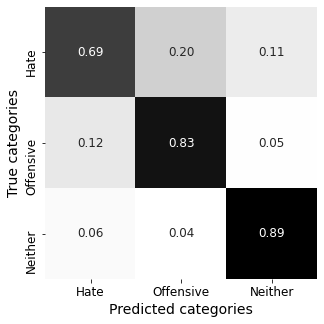

In [43]:
# Confusion matrix for Logistic Regression
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

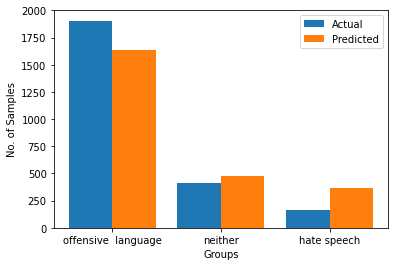

In [45]:
# Histogram for comparing actual and predicted samples
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['offensive  language','neither','hate speech']
yactual =pd.DataFrame(y_test).value_counts()
ypred =pd.DataFrame(y_preds).value_counts()
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, yactual, 0.4, label = 'Actual')
plt.bar(X_axis + 0.2, ypred, 0.4, label = 'Predicted')
  
plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("No. of Samples")
plt.legend()
plt.show()

#KNN Classifier

In [46]:
from sklearn.neighbors import KNeighborsClassifier

In [47]:
# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3,weights='distance',p=1)
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)

In [48]:
report = classification_report( y_test, knn_predictions )

In [49]:
# f1-score, recall, precision and accuracy
print(report)

              precision    recall  f1-score   support

           0       0.20      0.06      0.09       164
           1       0.82      0.89      0.86      1905
           2       0.45      0.39      0.41       410

    accuracy                           0.76      2479
   macro avg       0.49      0.45      0.45      2479
weighted avg       0.72      0.76      0.73      2479



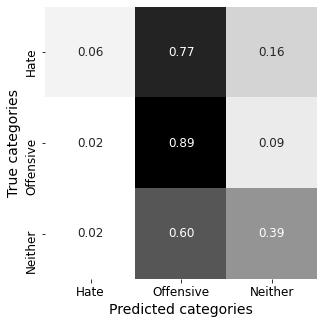

In [50]:
# Confusion matrix for KNN Classifier
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,knn_predictions)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

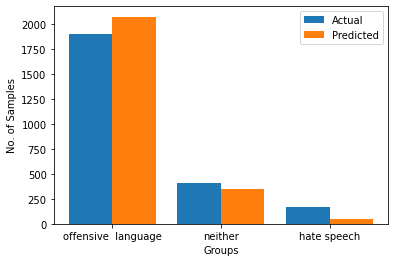

In [51]:
# Histogram for comparing actual and predicted samples
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['offensive  language','neither','hate speech']
yactual =pd.DataFrame(y_test).value_counts()
ypred =pd.DataFrame(knn_predictions).value_counts()
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, yactual, 0.4, label = 'Actual')
plt.bar(X_axis + 0.2, ypred, 0.4, label = 'Predicted')
  
plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("No. of Samples")
plt.legend()
plt.show()

## Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier()
modelrf = rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)

In [55]:
report = classification_report( y_test, rf_predictions )

In [56]:
# f1-score, recall, precision and accuracy
print(report)

              precision    recall  f1-score   support

           0       0.50      0.02      0.05       164
           1       0.85      0.99      0.91      1905
           2       0.89      0.56      0.69       410

    accuracy                           0.85      2479
   macro avg       0.75      0.53      0.55      2479
weighted avg       0.83      0.85      0.82      2479



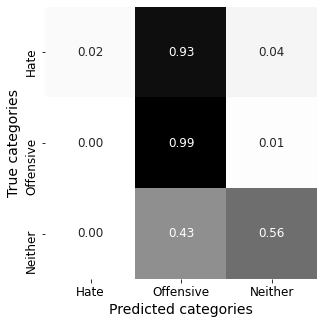

In [57]:
# Confusion matrix for Random Forest Classifier
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,rf_predictions)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

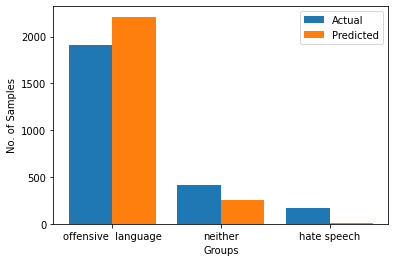

In [58]:
# Histogram for comparing actual and predicted samples
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['offensive  language','neither','hate speech']
yactual =pd.DataFrame(y_test).value_counts()
ypred =pd.DataFrame(rf_predictions).value_counts()
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, yactual, 0.4, label = 'Actual')
plt.bar(X_axis + 0.2, ypred, 0.4, label = 'Predicted')
  
plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("No. of Samples")
plt.legend()
plt.show()

## Linear Support Vector Classifier

In [59]:
# Linear Support Vector Classifier
from sklearn.svm import LinearSVC

clf = LinearSVC(C=0.01,class_weight='balanced',penalty='l1',dual = False,random_state=10)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.01, class_weight='balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=10, tol=0.0001,
          verbose=0)

In [60]:
linearsvc_pred = clf.predict(X_test)

In [61]:
report = classification_report( y_test, linearsvc_pred )

In [62]:
# f1-score, recall, precision and accuracy
print(report)

              precision    recall  f1-score   support

           0       0.44      0.57      0.49       164
           1       0.96      0.90      0.93      1905
           2       0.79      0.95      0.86       410

    accuracy                           0.89      2479
   macro avg       0.73      0.81      0.76      2479
weighted avg       0.90      0.89      0.89      2479



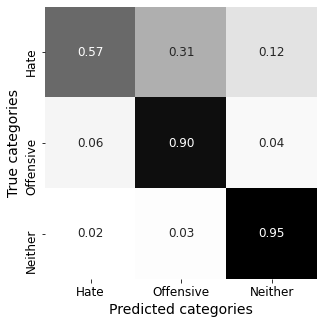

In [63]:
# Confusion matrix for Linear Support Vector Classifier
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,linearsvc_pred)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

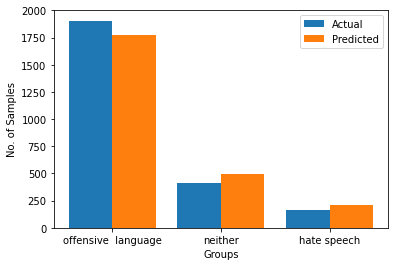

In [64]:
# Histogram for comparing actual and predicted samples
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['offensive  language','neither','hate speech']
yactual =pd.DataFrame(y_test).value_counts()
ypred =pd.DataFrame(linearsvc_pred).value_counts()
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, yactual, 0.4, label = 'Actual')
plt.bar(X_axis + 0.2, ypred, 0.4, label = 'Predicted')
  
plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("No. of Samples")
plt.legend()
plt.show()

##Gaussian Naive Bayes

In [65]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb_classifier = GaussianNB()
y_pred = nb_classifier.fit(X_train, y_train).predict(X_test)

In [66]:
report = classification_report( y_test, y_pred )

In [67]:
# f1-score, recall, precision and accuracy
print(report)

              precision    recall  f1-score   support

           0       0.12      0.30      0.17       164
           1       0.87      0.73      0.80      1905
           2       0.51      0.55      0.53       410

    accuracy                           0.68      2479
   macro avg       0.50      0.53      0.50      2479
weighted avg       0.76      0.68      0.71      2479



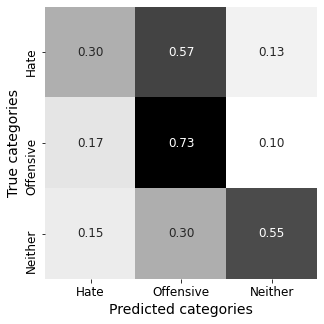

In [68]:
# Confusion Matrix for Gaussian Naive Bayes
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_pred)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

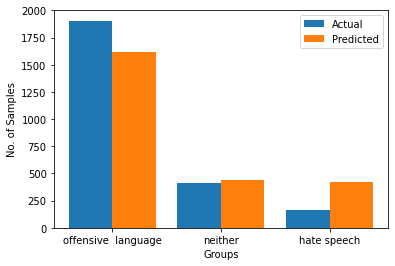

In [69]:
# Histogram for comparing actual and predicted samples
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['offensive  language','neither','hate speech']
yactual =pd.DataFrame(y_test).value_counts()
ypred =pd.DataFrame(y_pred).value_counts()
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, yactual, 0.4, label = 'Actual')
plt.bar(X_axis + 0.2, ypred, 0.4, label = 'Predicted')
  
plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("No. of Samples")
plt.legend()
plt.show()

##Decision Tree

In [70]:
# Decision Tree 
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [71]:
ypred = clf.predict(X_test)

In [72]:
report = classification_report( y_test, ypred )

In [73]:
# f1-score, recall, precision and accuracy
print(report)

              precision    recall  f1-score   support

           0       0.34      0.26      0.29       164
           1       0.92      0.93      0.92      1905
           2       0.81      0.81      0.81       410

    accuracy                           0.87      2479
   macro avg       0.69      0.67      0.68      2479
weighted avg       0.86      0.87      0.86      2479



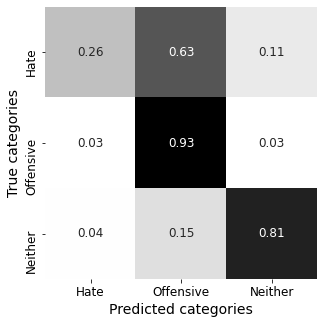

In [74]:
# Confusion Matrix for Decision Tree
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,ypred)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

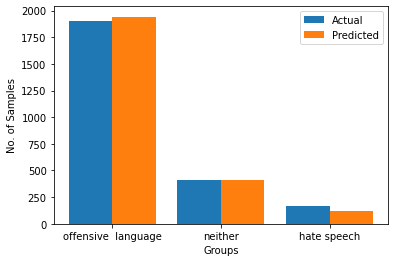

In [75]:
# Histogram for comparing actual and predicted samples
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['offensive  language','neither','hate speech']
yactual = pd.DataFrame(y_test).value_counts()
ypred = pd.DataFrame(ypred).value_counts()
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, yactual, 0.4, label = 'Actual')
plt.bar(X_axis + 0.2, ypred, 0.4, label = 'Predicted')
  
plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("No. of Samples")
plt.legend()
plt.show()